In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.vector_ar.vecm import select_coint_rank, coint_johansen
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.filters.hp_filter import hpfilter
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('ggplot')

In [180]:
slv = pd.read_csv(f"data/SLV-Prices.csv")
gld = pd.read_csv(f"data/GLD-Prices.csv")

cpi = pd.read_csv(f"data/CPI.csv")
gdp = pd.read_csv(f"data/GDP.csv")
yields = pd.read_csv(f"data/YIELDS.csv")


gdp.rename(columns={'observation_date': 'Date'}, inplace=True)
cpi.rename(columns={'CORESTICKM159SFRBATL': 'CPI', 'observation_date': 'Date'}, inplace=True)
yields.rename(columns={'MMTY': 'Yields', 'observation_date': 'Date'}, inplace=True)


gdp['Date'] = pd.to_datetime(gdp['Date'])
cpi['Date'] = pd.to_datetime(cpi['Date'])
yields['Date'] = pd.to_datetime(yields['Date'])


slv['Date'] = pd.to_datetime(slv['Date'])
gld['Date'] = pd.to_datetime(gld['Date'])

In [181]:
#forward fill economic data

gdp_filled = gdp.set_index('Date').resample('D').ffill()
cpi_filled = cpi.set_index('Date').resample('D').ffill()
yields_filled = yields.set_index('Date').resample('D').ffill()
slv = slv.set_index('Date').resample('D').ffill()
gld = gld.set_index('Date').resample('D').ffill()

gdp_filled = gdp_filled.reset_index()
gdp_filled.insert(0, 'index', range(len(gdp_filled)))

cpi_filled = cpi_filled.reset_index()
cpi_filled.insert(0, 'index', range(len(cpi_filled)))

yields_filled = yields_filled.reset_index()
yields_filled.insert(0, 'index', range(len(yields_filled)))

slv = slv.reset_index()
slv.insert(0, 'index', range(len(slv)))

gld = gld.reset_index()
gld.insert(0, 'index', range(len(gld)))

In [182]:
print(gdp_filled.shape, cpi_filled.shape, yields_filled.shape)

(1005, 3) (1036, 3) (1372, 3)


In [183]:
print(gld.shape, slv.shape)

(7292, 7) (6766, 7)


In [184]:
start_date, end_date = '2021-12-25', '2024-10-01'
slv = slv[(slv['Date'] >= start_date) & (slv['Date'] <= end_date)].reset_index(drop=True)
gld = gld[(gld['Date'] >= start_date) & (gld['Date'] <= end_date)].reset_index(drop=True)

yields_filled = yields_filled[(yields_filled['Date'] >= start_date) & (yields_filled['Date'] <= end_date)].reset_index(drop=True)
cpi_filled = cpi_filled[(cpi_filled['Date'] >= start_date) & (cpi_filled['Date'] <= end_date)].reset_index(drop=True)
gdp_filled = gdp_filled[(gdp_filled['Date'] >= start_date) & (gdp_filled['Date'] <= end_date)].reset_index(drop=True)                                      

In [185]:
yields_filled = yields_filled.iloc[7:].reset_index(drop=True)
gld = gld.iloc[7:].reset_index(drop=True)
slv = slv.iloc[7:].reset_index(drop=True)

In [186]:
print(gdp_filled.shape, cpi_filled.shape, yields_filled.shape)

(1005, 3) (1005, 3) (1005, 3)


In [187]:
print(gld.shape, slv.shape)


(1005, 7) (1005, 7)


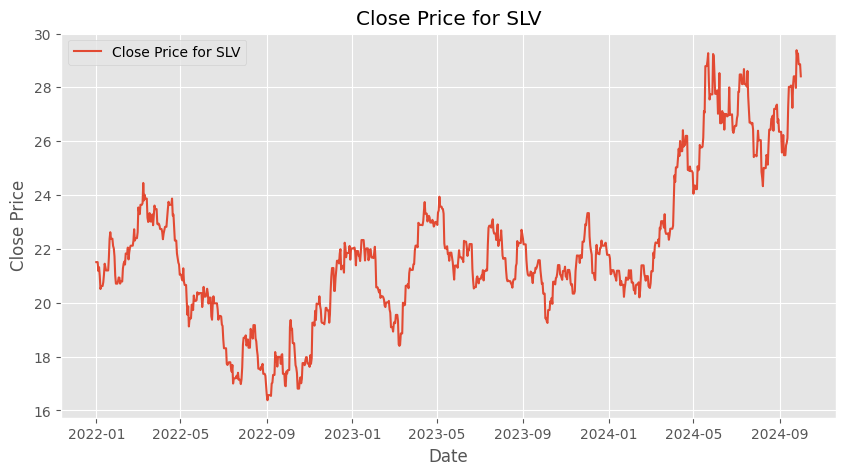

In [188]:
plt.figure(figsize=(10, 5)) 
plt.plot(slv['Date'], slv['Close'], label='Close Price for SLV') 
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title("Close Price for SLV") 
plt.grid(True) 
plt.legend() 
plt.show() 

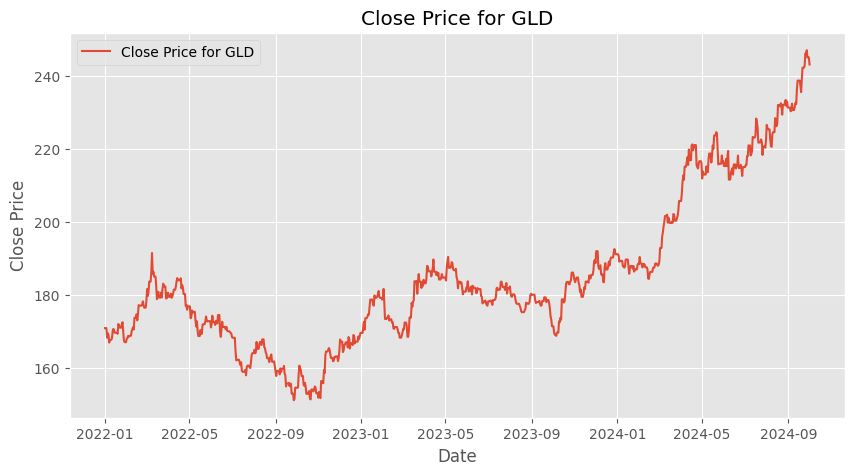

In [189]:
plt.figure(figsize=(10, 5))  
plt.plot(gld['Date'], gld['Close'], label='Close Price for GLD')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title("Close Price for GLD") 
plt.grid(True) 
plt.legend() 
plt.show()  

In [190]:
def detrend_hf(series, lamb):
    cycle, trend = hpfilter(series, lamb=1600)
    plt.figure(figsize=(10, 6))
    plt.plot(series, label='Original Series')
    plt.plot(trend, label='Trend Component')
    plt.plot(cycle, label='Detrended Series (Cyclical Component)')
    plt.legend()
    plt.title('Detrending Using HP Filter')
    plt.show()
    return cycle
    
    

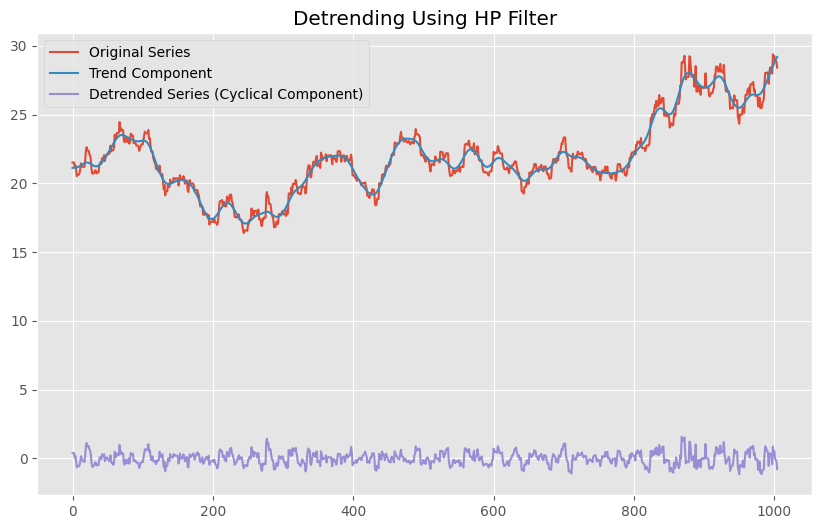

In [191]:
slv["Close"] = detrend_hf(slv["Close"], 10_950_000)  

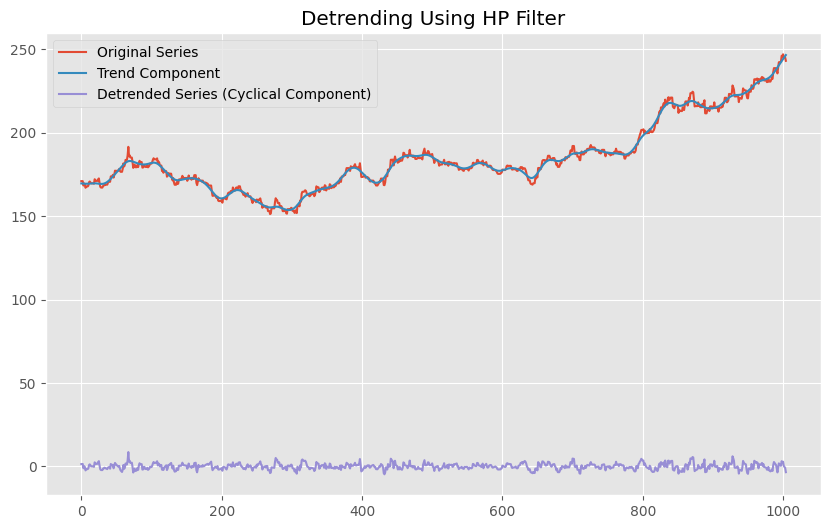

In [192]:
gld["Close"] = detrend_hf(gld["Close"], 7_600_000)  

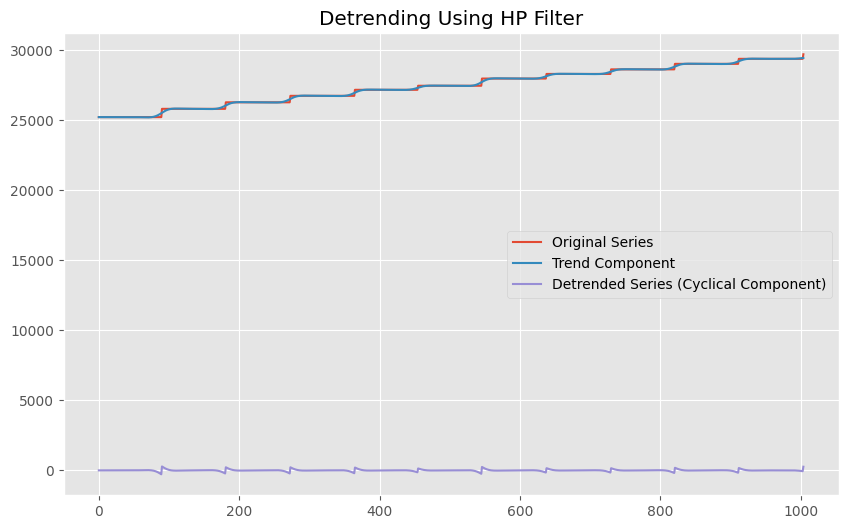

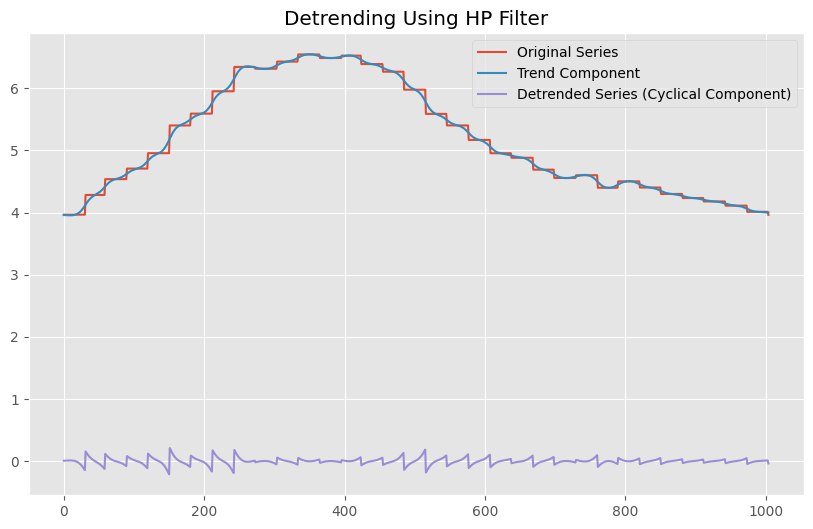

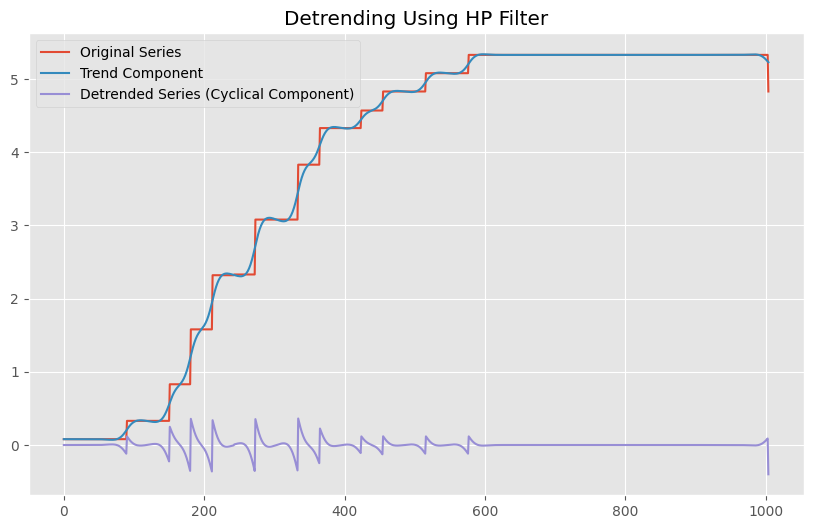

In [193]:
gdp_filled["GDP"] = detrend_hf(gdp_filled["GDP"], 1600)
cpi_filled["CPI"] = detrend_hf(cpi_filled["CPI"], 1600)
yields_filled["Yields"] = detrend_hf(yields_filled["Yields"], 1600)

In [194]:
def perform_stationarity_tests(series, signif=0.05, verbose=False):
    """
    Performs both ADF and KPSS tests on the given series.
    """
    results = {}

    # Augmented Dickey-Fuller Test
    try:
        adf_test = adfuller(series, autolag='AIC')
        adf_stat = adf_test[0]
        adf_pvalue = adf_test[1]
        results['ADF'] = {'Test Statistic': adf_stat, 'p-value': adf_pvalue}
        if verbose:
            print('ADF Test:')
            print(f"Test Statistic: {adf_stat}, p-value: {adf_pvalue}")
    except Exception as e:
        results['ADF'] = None

    # KPSS Test
    try:
        kpss_test = kpss(series, regression='c', nlags='auto')
        kpss_stat = kpss_test[0]
        kpss_pvalue = kpss_test[1]
        results['KPSS'] = {'Test Statistic': kpss_stat, 'p-value': kpss_pvalue}
        if verbose:
            print('KPSS Test:')
            print(f"Test Statistic: {kpss_stat}, p-value: {kpss_pvalue}")
    except Exception as e:
        results['KPSS'] = None

    return results


def determine_optimal_differencing(series, max_d=2, signif=0.05, verbose=False):
    """
    Determines the optimal differencing order 'd' for the series.
    """
    for d in range(max_d + 1):
        if d == 0:
            differenced_series = series.copy()
        else:
            differenced_series = series.diff(d).dropna()
        test_results = perform_stationarity_tests(
            differenced_series, signif=signif, verbose=verbose)
        adf_pvalue = test_results['ADF']['p-value'] if test_results['ADF'] else None
        kpss_pvalue = test_results['KPSS']['p-value'] if test_results['KPSS'] else None

        adf_stationary = adf_pvalue is not None and adf_pvalue < signif
        kpss_stationary = kpss_pvalue is not None and kpss_pvalue >= signif

        if verbose:
            print(
                f"Differencing order d={d}: ADF stationary={adf_stationary}, KPSS stationary={kpss_stationary}")

        if adf_stationary and kpss_stationary:
            if verbose:
                print(f"Optimal differencing order determined: d={d}")
            return d

    if verbose:
        print(
            f"No optimal differencing order found up to d={max_d}. Using d={max_d}")
    return max_d

# Both Commodities Differencing
Since both tests agree for both commodities in their original form SLV and GLD are non stationary however at the first difference level they become stationary series. This means they are integrated at a property of 1.

In [195]:
def johanassonTest(series, modelType, diffOrder):
    j_test = coint_johansen(series, modelType, diffOrder)
    print("Eigenvalues:\n", j_test.eig)
    print("Trace Statistics:\n", j_test.lr1)
    print("Max Eigenvalue Statistics:\n", j_test.lr2)
    print("Critical Values of Trace statistic(90%, 95%, 99%):\n", j_test.cvt)
    print("Critical Values of max eig value statistic(90%, 95%, 99%):\n", j_test.cvt)

In [196]:
print(f"\n GDP Stationarity Testing:")
d = determine_optimal_differencing(gdp_filled['GDP'], verbose=True)

print(f"\n CPI Stationarity Testing:")
d = determine_optimal_differencing(cpi_filled['CPI'], verbose=True)

print(f"\n CPI Stationarity Testing:")
d = determine_optimal_differencing(yields_filled['Yields'], verbose=True)



 GDP Stationarity Testing:
ADF Test:
Test Statistic: -10.434069019122488, p-value: 1.5830922917173642e-18
KPSS Test:
Test Statistic: 0.005131878761815358, p-value: 0.1
Differencing order d=0: ADF stationary=True, KPSS stationary=True
Optimal differencing order determined: d=0

 CPI Stationarity Testing:
ADF Test:
Test Statistic: -15.542796013937203, p-value: 2.1486370011986518e-28
KPSS Test:
Test Statistic: 0.00474903649994851, p-value: 0.1
Differencing order d=0: ADF stationary=True, KPSS stationary=True
Optimal differencing order determined: d=0

 CPI Stationarity Testing:
ADF Test:
Test Statistic: -13.254814494969064, p-value: 8.630439933189088e-25
KPSS Test:
Test Statistic: 0.004678872717372071, p-value: 0.1
Differencing order d=0: ADF stationary=True, KPSS stationary=True
Optimal differencing order determined: d=0


In [197]:
slv_gld_merged = pd.DataFrame({'SLV': slv['Close'], 'GLD': gld['Close']})

In [198]:
johanassonTest(slv_gld_merged, -1, 0)

Eigenvalues:
 [0.15751371 0.1213611 ]
Trace Statistics:
 [301.98228184 129.8988011 ]
Max Eigenvalue Statistics:
 [172.08348074 129.8988011 ]
Critical Values of Trace statistic(90%, 95%, 99%):
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]]
Critical Values of max eig value statistic(90%, 95%, 99%):
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]]


## Proving Cointegration
Both the trace statistic and max eigenvalue statistic indicate strong evidence of cointegration.
This suggests that there are at least 2 cointegrating relationships among the SLV and GLD in the dataset.

In [199]:
print(f"\n SLV Stationarity Testing:")
close_series = slv['Close']
d = determine_optimal_differencing(close_series, verbose=True)

print(f"\n GLD Stationarity Testing:")
close_series = gld['Close']
d = determine_optimal_differencing(close_series, verbose=True)


 SLV Stationarity Testing:
ADF Test:
Test Statistic: -11.462421574510673, p-value: 5.5132554540401884e-21
KPSS Test:
Test Statistic: 0.0051699800863834935, p-value: 0.1
Differencing order d=0: ADF stationary=True, KPSS stationary=True
Optimal differencing order determined: d=0

 GLD Stationarity Testing:
ADF Test:
Test Statistic: -11.608936273944247, p-value: 2.5407429078089828e-21
KPSS Test:
Test Statistic: 0.005186370582857957, p-value: 0.1
Differencing order d=0: ADF stationary=True, KPSS stationary=True
Optimal differencing order determined: d=0


In [200]:
macro_cycles = pd.DataFrame({'GDP': gdp_filled['GDP'], 'CPI': cpi_filled['CPI'], "Yields" : yields_filled['Yields']})

In [201]:
macro_cycles.head()

,GDP,CPI,Yields
0,0.007107,0.006352,0.000003
1,0.010386,0.007028,0.000004
2,0.013661,0.007700,0.000006
3,0.016921,0.008359,0.000007
4,0.020145,0.008993,0.000009


In [202]:
slv_gld_merged.head()

,SLV,GLD
0,0.390781,1.385798
1,0.387839,1.426724
2,0.384653,1.466784
3,0.050736,-1.125781
4,0.185362,0.146357


In [203]:
print("Number of NaNs in macro_cycles:", np.isnan(macro_cycles).sum())
print("Number of infs in macro_cycles:", np.isinf(macro_cycles).sum())

macro_cycles_cleaned = macro_cycles.replace([np.inf, -np.inf], np.nan).ffill()

# Check again for NaNs and infs
print("Number of NaNs after cleaning:", np.isnan(macro_cycles_cleaned).sum())
print("Number of infs after cleaning:", np.isinf(macro_cycles_cleaned).sum())


Number of NaNs in macro_cycles: GDP       0
CPI       0
Yields    0
dtype: int64
Number of infs in macro_cycles: GDP       0
CPI       0
Yields    0
dtype: int64
Number of NaNs after cleaning: GDP       0
CPI       0
Yields    0
dtype: int64
Number of infs after cleaning: GDP       0
CPI       0
Yields    0
dtype: int64


In [204]:
macro_cycles_cleaned.shape

(1005, 3)

In [205]:
slv_gld_merged.shape

(1005, 2)

In [206]:
slv_gld_merged_aligned = slv_gld_merged.loc[macro_cycles_cleaned.index]

In [207]:
from statsmodels.tsa.vector_ar.vecm import VECM
model = VECM(slv_gld_merged_aligned, k_ar_diff=0, coint_rank=1, exog=macro_cycles_cleaned)
result = model.fit()
residuals = result.resid


print(result.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation SLV
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
exog1       9.939e-05      0.000      0.490      0.624      -0.000       0.000
exog2          0.0568      0.212      0.268      0.789      -0.359       0.473
exog3          0.1456      0.159      0.916      0.360      -0.166       0.457
Det. terms outside the coint. relation & lagged endog. parameters for equation GLD
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
exog1         -0.0002      0.001     -0.209      0.834      -0.002       0.001
exog2          0.1213      0.854      0.142      0.887      -1.553       1.795
exog3          0.9665      0.640      1.511      0.131      -0.287       2.220
                Loading coefficients (alpha)

In [208]:
perform_stationarity_tests(residuals[:, 0], verbose=True)

ADF Test:
Test Statistic: -11.745301885599352, p-value: 1.2456092296214396e-21
KPSS Test:
Test Statistic: 0.004598852517336717, p-value: 0.1


{'ADF': {'Test Statistic': -11.745301885599352,
  'p-value': 1.2456092296214396e-21},
 'KPSS': {'Test Statistic': 0.004598852517336717, 'p-value': 0.1}}

In [209]:
residuals.shape

(1004, 2)

## Results are stationary

Since the residuals are stationary which confirms that the original time seriers are cointegrated and that there is a long-term equilibrium betwen the series and deviations from the equilibrium are temporary and revert back to the mean

In [220]:
residuals_series = pd.Series(residuals[:,0], index=slv.index)

In [231]:
residuals_mean = residuals_series.mean()
residuals_std = residuals_series.std()

threshold = 1.0
upper_threshold = residuals_mean + threshold * residuals_std
lower_threshold = residuals_mean - threshold * residuals_std

### Found residuals
These residuals using their means, standard deviations we can develop a mean reversion strategy to buy and sell orders if they leave this certain threshold which we can configure